    Usable both for regression and classification.
    No need to do feature pre-processing / normalization. Each feature is processed independently and the splitting of the data doesn't depend on the absolute scale of the feature.
    
    Goal: find the sequence of questions (==> the set of rules) that has the best accuracy at classifying the data in the fewest steps.
        - more informative features higher in the tree of questions (closer to the root)
        - each decision splits the data into two branches based on some feature value above or below a threshold. 
        - if a feature has a low feature importance value, that doesn't necessarily mean that the feature is not important for prediction. It simply means that the particular feature wasn't chosen at an early level of the tree and this could be because the future may be identical or highly correlated with another informative feature and so doesn't provide any new additional signal for prediction.
        - feature importance values don't tell us which specific classes a feature might be especially predictive for, and they also don't indicate more complex relationships between features that may influence prediction. 

     "best split" = the results should produce as homogeneous a set of classes as possible. 
         criteria to compute the best split e.g. information game
         
      DecisionTreeClassifier parameters (ways to control overfitting; in practice adjusting one only e.g. max_depth is anough to reduce overfitting):
      - max_depth = number of split points. 
      - min_samples_leaf = threshold for minimum # of data instances a leaf can have to avoid further splitting
      - max_leaf_nodes = limits total number of leaves in the tree
 

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_blobs
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

from matplotlib.colors import ListedColormap

from adspy_shared_utilities import plot_feature_importances
from adspy_shared_utilities import plot_decision_tree
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot


    FRUIT DATASET


In [2]:
# fruits dataset
fruits = pd.read_table('fruit_data_with_colors.txt')
print (pd.DataFrame(fruits).info())

feature_names_fruits = ['height', 'width', 'mass', 'color_score']
X_fruits = fruits[feature_names_fruits]
y_fruits = fruits['fruit_label']

print (X_fruits.head())
print(y_fruits.head())

target_names_fruits = ['apple', 'mandarin', 'orange', 'lemon']

X_fruits_2d = fruits[['height', 'width']]
y_fruits_2d = fruits['fruit_label']

X_train_fruit, X_test_fruit, y_train_fruit, y_test_fruit = train_test_split(X_fruits.values,
                                                                            y_fruits.values,
                                                                            random_state = 0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fruit_label    59 non-null     int64  
 1   fruit_name     59 non-null     object 
 2   fruit_subtype  59 non-null     object 
 3   mass           59 non-null     int64  
 4   width          59 non-null     float64
 5   height         59 non-null     float64
 6   color_score    59 non-null     float64
dtypes: float64(3), int64(2), object(2)
memory usage: 3.4+ KB
None
   height  width  mass  color_score
0     7.3    8.4   192         0.55
1     6.8    8.0   180         0.59
2     7.2    7.4   176         0.60
3     4.7    6.2    86         0.80
4     4.6    6.0    84         0.79
0    1
1    1
2    1
3    2
4    2
Name: fruit_label, dtype: int64


In [3]:
iris = load_iris()
print(pd.DataFrame(iris.data).info())
print (iris.keys())

print (pd.DataFrame(iris.data).head())
print (pd.DataFrame(iris.target).head())

X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(iris.data, 
                                                                        iris.target, 
                                                                        random_state = 3)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       150 non-null    float64
 1   1       150 non-null    float64
 2   2       150 non-null    float64
 3   3       150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB
None
dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
     0    1    2    3
0  5.1  3.5  1.4  0.2
1  4.9  3.0  1.4  0.2
2  4.7  3.2  1.3  0.2
3  4.6  3.1  1.5  0.2
4  5.0  3.6  1.4  0.2
   0
0  0
1  0
2  0
3  0
4  0


---
# DECISION TREES

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.73


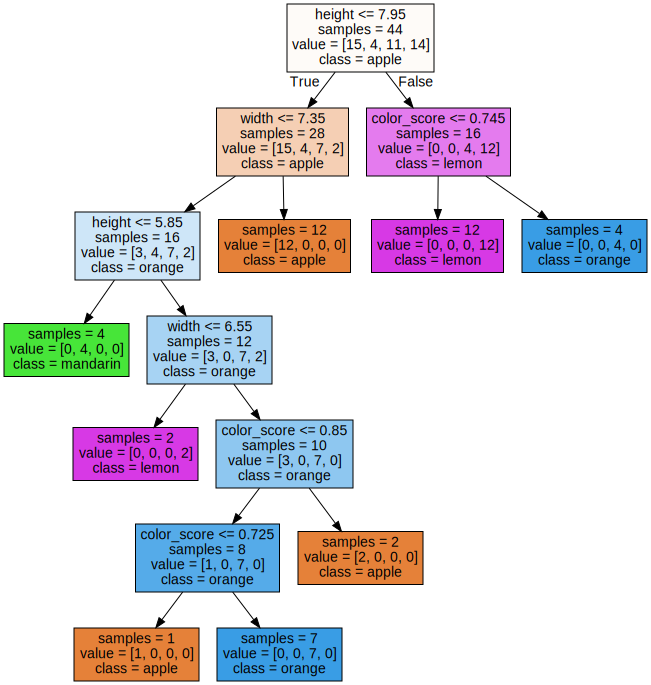

In [4]:
clf_fruit = DecisionTreeClassifier().fit(X_train_fruit, 
                                         y_train_fruit)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf_fruit.score(X_train_fruit, y_train_fruit)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf_fruit.score(X_test_fruit, y_test_fruit)))

plot_decision_tree(clf_fruit, 
                   feature_names_fruits, 
                   target_names_fruits)

<IPython.core.display.Javascript object>


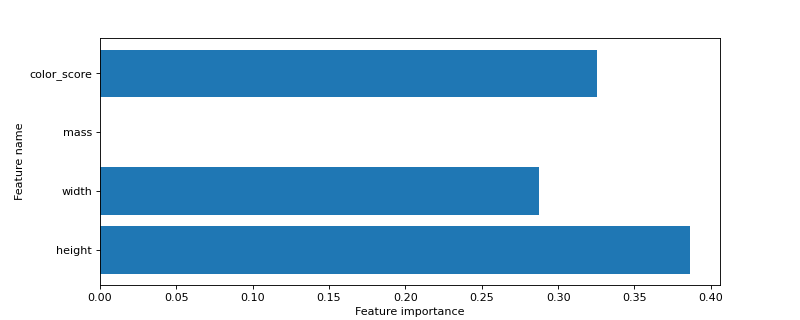

Feature importances: [0.3866715  0.28763909 0.         0.3256894 ]


In [5]:
plt.figure(figsize=(10,4), dpi=80)
plot_feature_importances(clf_fruit, feature_names_fruits)
plt.show()
print('Feature importances: {}'.format(clf_fruit.feature_importances_))

<IPython.core.display.Javascript object>


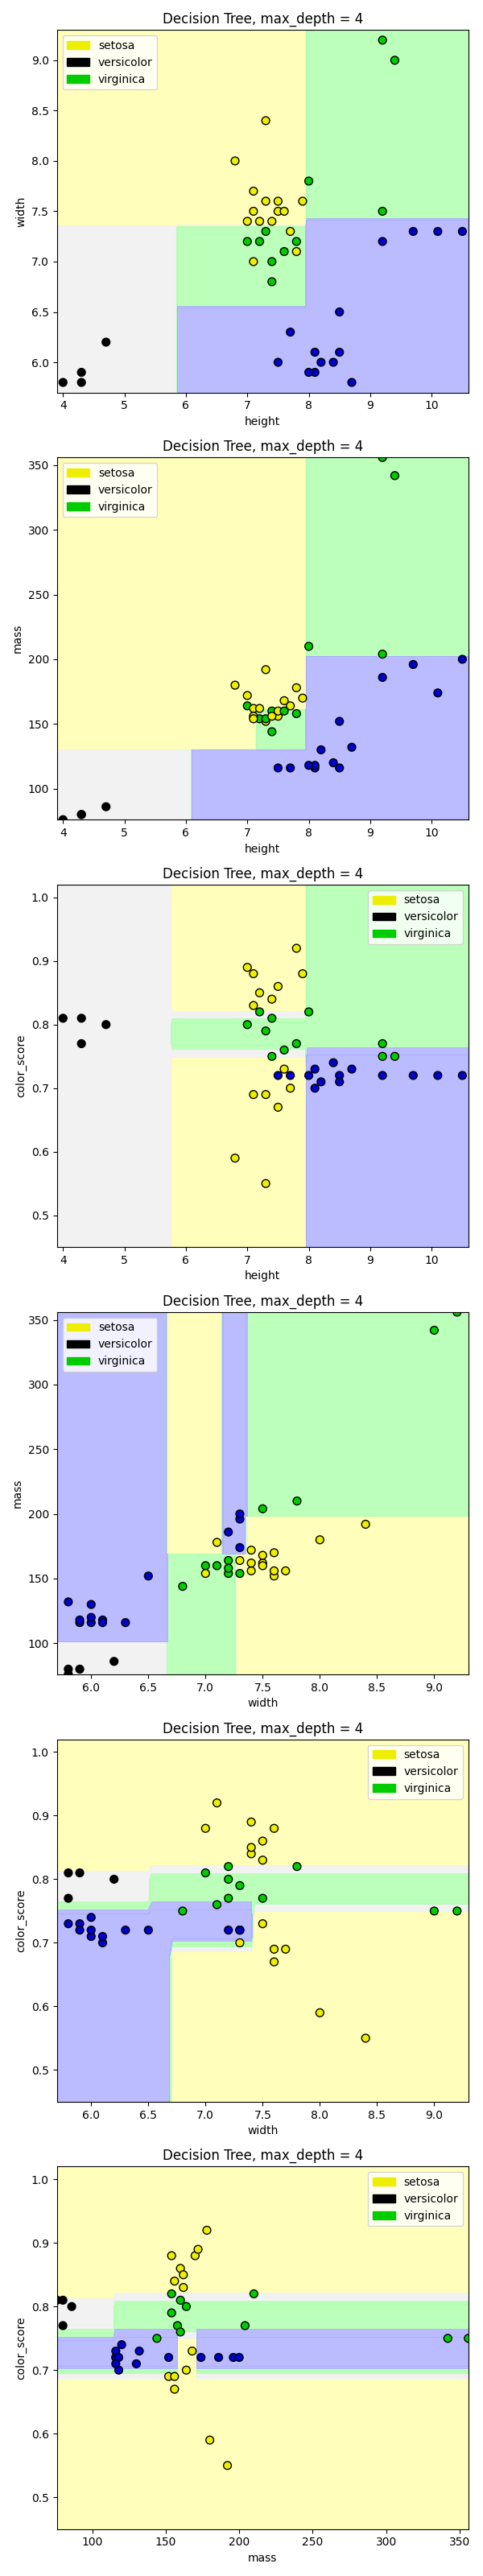

   feature1_index  feature2_index  train_accuracy  test_accuracy
0               0               1        0.931818       0.733333
1               0               2        0.886364       0.733333
2               0               3        0.954545       0.800000
3               1               2        0.954545       0.733333
4               1               3        1.000000       0.733333
5               2               3        1.000000       0.800000


In [6]:
# Train decision trees splitting on pairs of two features
# 6 subplots, 1 per sub-dataset extracted from the training data
fig, subaxes = plt.subplots(6,1, figsize=(6, 32))

# 6 pairs of column indexes to be retrieved from the original dataset
pair_list = [[0,1], [0,2], [0,3], [1,2], [1,3], [2,3]]
tree_max_depth = 4

train_test_accuracy = []

for pair, axis in zip(pair_list, subaxes):
    # extract specified pairs of columns from the training dataset
    X = np.array(X_train_fruit[:, pair])
    y = y_train_fruit
    
    # train a decision tree
    clf = DecisionTreeClassifier(max_depth=tree_max_depth).fit(X, y)
    
    # evaluation criteria
    train_accuracy = clf.score(X, y)
    test_accuracy = clf.score(X_test_fruit[:, pair], y_test_fruit)
    train_test_accuracy.append([pair[0], pair[1],  train_accuracy, test_accuracy])

    title = 'Decision Tree, max_depth = {:d}'.format(tree_max_depth)
    plot_class_regions_for_classifier_subplot(clf, X, y, None,
                                             None, title, axis,
                                             iris.target_names)
    
    axis.set_xlabel(feature_names_fruits[pair[0]])
    axis.set_ylabel(feature_names_fruits[pair[1]])
    
    
plt.tight_layout()
plt.show()

train_test_accuracy_df = pd.DataFrame(train_test_accuracy)
train_test_accuracy_df.columns = ["feature1_index", "feature2_index", "train_accuracy", "test_accuracy"]
print (train_test_accuracy_df)



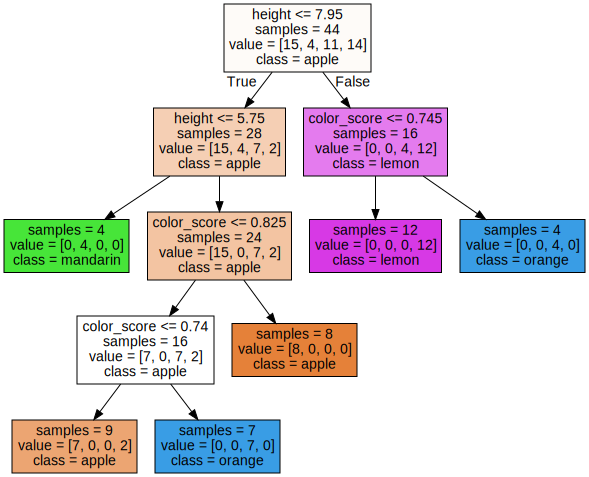

In [7]:
# based on inspection of train test accuracies of the 6 classifiers attempted per pair of feature
# this one seems to have good train-test accuracies, compared to the others
pair = [0,3]

# extract specified pairs of columns from the training dataset
X = np.array(X_train_fruit[:, pair])
y = y_train_fruit

# train a decision tree
clf = DecisionTreeClassifier(max_depth=tree_max_depth).fit(X, y)

plot_decision_tree(clf, 
                   list([feature_names_fruits[pair[0]], feature_names_fruits[pair[1]]]), 
                   target_names_fruits)


    IRIS

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.95


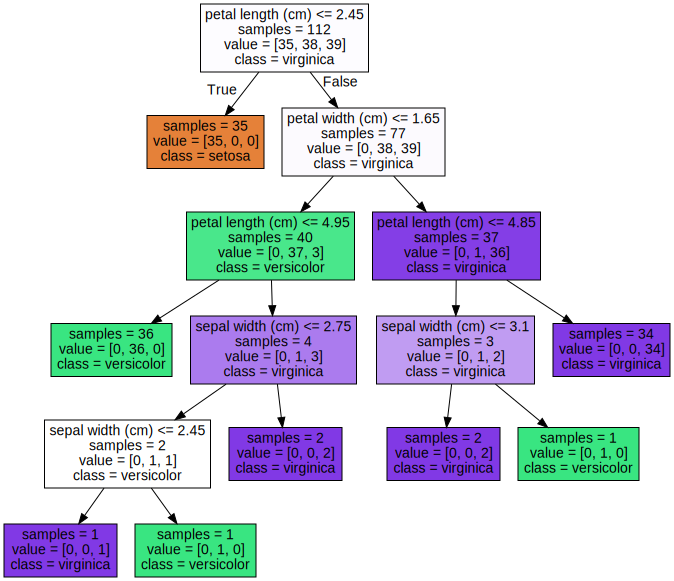

In [8]:
clf_iris = DecisionTreeClassifier().fit(X_train_iris, 
                                         y_train_iris)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf_iris.score(X_train_iris, y_train_iris)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf_iris.score(X_test_iris, y_test_iris)))

plot_decision_tree(clf_iris, 
                   iris.feature_names, 
                   iris.target_names)

<IPython.core.display.Javascript object>


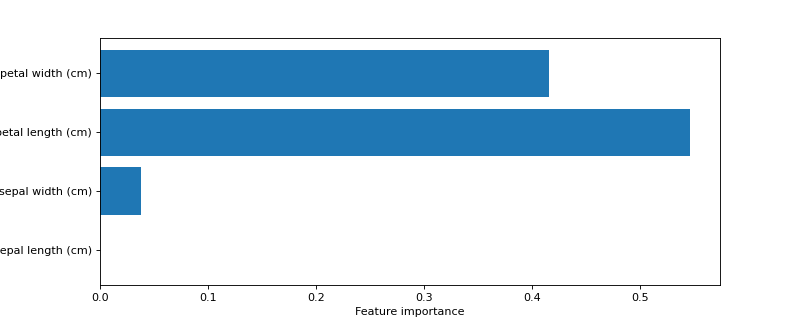

Feature importances: [0.         0.0379858  0.54643762 0.41557658]


In [9]:
plt.figure(figsize=(10,4), dpi=80)
plot_feature_importances(clf_iris, iris.feature_names)
plt.show()
print('Feature importances: {}'.format(clf_iris.feature_importances_))

<IPython.core.display.Javascript object>


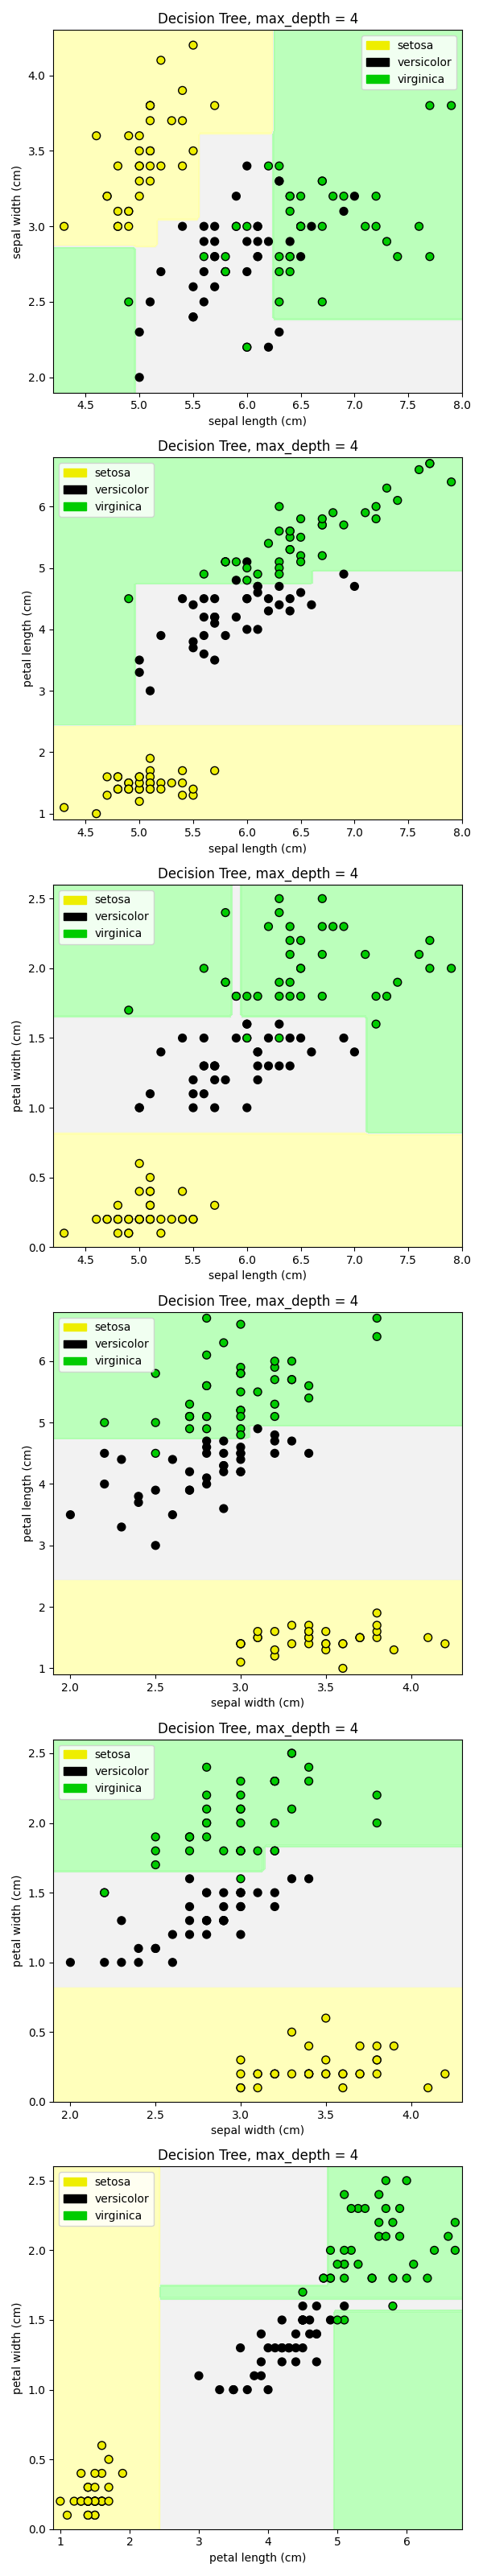

   feature1_index  feature2_index  train_accuracy  test_accuracy
0               0               1        0.857143       0.710526
1               0               2        0.982143       0.921053
2               0               3        0.973214       0.947368
3               1               2        0.982143       0.921053
4               1               3        0.964286       0.947368
5               2               3        0.982143       0.947368


In [10]:
# Train decision trees splitting on pairs of two features
# 6 subplots, 1 per sub-dataset extracted from the training data
fig, subaxes = plt.subplots(6,1, figsize=(6, 32))

# 6 pairs of column indexes to be retrieved from the original dataset
pair_list = [[0,1], [0,2], [0,3], [1,2], [1,3], [2,3]]
tree_max_depth = 4

train_test_accuracy = []
for pair, axis in zip(pair_list, subaxes):
    # extract specified pairs of columns from the training dataset
    X = X_train_iris[:, pair]
    y = y_train_iris
    
    # train a  DecisionTreeClassifier (which is expecting 2 features as input).
    clf = DecisionTreeClassifier(max_depth=tree_max_depth).fit(X, y)
    
    # evaluation criteria
    train_accuracy = clf.score(X, y)
    test_accuracy = clf.score(X_test_iris[:, pair], y_test_iris)
    train_test_accuracy.append([pair[0], pair[1],  train_accuracy, test_accuracy])
   

    title = 'Decision Tree, max_depth = {:d}'.format(tree_max_depth)
    plot_class_regions_for_classifier_subplot(clf, X, y, None,
                                             None, title, axis,
                                             iris.target_names)
   
    axis.set_xlabel(iris.feature_names[pair[0]])
    axis.set_ylabel(iris.feature_names[pair[1]])
    
plt.tight_layout()
plt.show()

train_test_accuracy_df = pd.DataFrame(train_test_accuracy)
train_test_accuracy_df.columns = ["feature1_index", "feature2_index", "train_accuracy", "test_accuracy"]
print (train_test_accuracy_df)



---
# REAL WORLD DATASET: BREAST CANCER    
    
---

In [11]:
from sklearn.datasets import load_breast_cancer
# Breast cancer dataset for classification
cancer = load_breast_cancer()
(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)
print ("Type of data structure: ", type(cancer))
print ("Keys: ", cancer.keys())
print ("Feature names: ", cancer["feature_names"])

# convert to dataframe
cancerdf = pd.DataFrame(cancer.data, columns=cancer.feature_names)
cancerdf['target'] = pd.Series(cancer.target)
counts = cancerdf.target.value_counts(ascending=True)
counts.index = "malignant benign".split()
print ("Distribution of labelled samples: ")
print(counts)
print ("-------------------------------------------")
print (cancerdf.head(5))

Type of data structure:  <class 'sklearn.utils.Bunch'>
Keys:  dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
Feature names:  ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Distribution of labelled samples: 
malignant    212
benign       357
Name: target, dtype: int64
-------------------------------------------
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.8

In [12]:
X_train_BC, X_test_BC, y_train_BC, y_test_BC = train_test_split(X_cancer, y_cancer, random_state = 0)

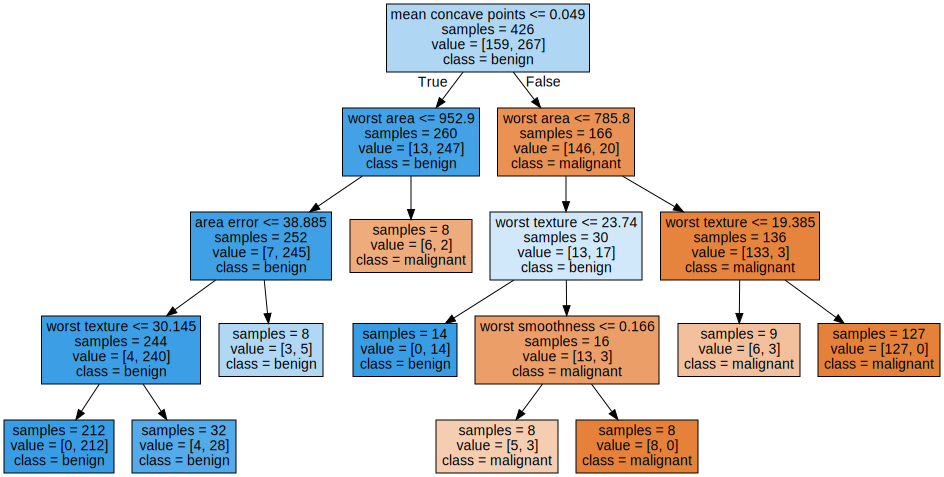

In [13]:
clf = DecisionTreeClassifier(max_depth = 4, 
                             min_samples_leaf = 8,
                             random_state = 0).fit(X_train_BC, y_train_BC)

plot_decision_tree(clf, cancer.feature_names, cancer.target_names)

Breast cancer dataset: decision tree
Accuracy of DT classifier on training set: 0.96
Accuracy of DT classifier on test set: 0.94


<IPython.core.display.Javascript object>


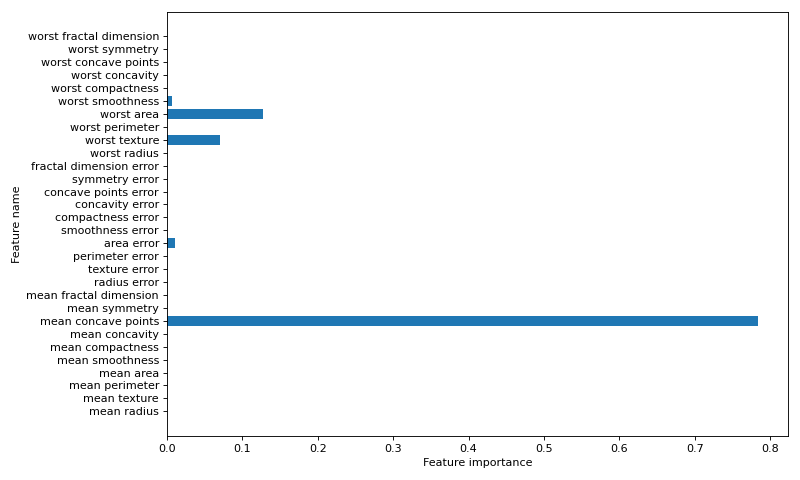

In [14]:
print('Breast cancer dataset: decision tree')
print('Accuracy of DT classifier on training set: {:.2f}'
     .format(clf.score(X_train_BC, y_train_BC)))
print('Accuracy of DT classifier on test set: {:.2f}'
     .format(clf.score(X_test_BC, y_test_BC)))

plt.figure(figsize=(10,6),dpi=80)
plot_feature_importances(clf, cancer.feature_names)
plt.tight_layout()

plt.show()